## Описание

Имеются результаты A/B теста**, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

** Данные взяты из материалов курса **Karpov Courses** "Аналитик данных" 

**Импортируем необходимые для работы бибилиотеки**

In [1]:
#Для работы с данными
import pandas as pd
import numpy as np

#Для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt

#Для статистических выводов
import scipy.stats as stats
from scipy.stats import levene
from scipy.stats import chi2_contingency 

**Загрузим файл с результатами тестирования и проведем разведочный анализ**

In [2]:
df = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/veWQXEIdZMOzXQ", sep=";")

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
#Посмотрим на общую информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [5]:
#Нулевых значений не обнаружено
df.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
#В датасете отсутствуют повторяющиеся значения user_id
df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [7]:
#Проверим показатели Revenue на отрицательные значения, а также посмотрим на максимальные и минимальные значения
df.revenue.max()

37433

In [8]:
df.revenue.min()

0

In [9]:
#Посмотрим на распределение пользователей по группам
df.groupby('testgroup').agg({'user_id':'nunique', 'revenue': 'sum'}).reset_index()

,testgroup,user_id,revenue
0,a,202103,5136189
1,b,202667,5421603


**Общая информация**

- Нулевых значений (NaN) в датасете не обнаружено;
- В датасете **404 770** уникальных пользователя;
- Отрицательные значения Revenue отсутствуют. Максимальный показатель - **37 433**, минимальный - 0;
- Контрольная группа(**a**) - **202 103** **уникальных** пользователя, тестовая(**b**) - **202 667** **уникальных**.

In [10]:
#Контрольная группа
df.query('testgroup == "a"').revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [11]:
#Контрольная группа. Общая выручка
df.query('testgroup == "a"').revenue.sum()

5136189

In [12]:
#Контрольная группа. Средний показатель выручки
df.query('testgroup == "a"').revenue.describe().iloc[1]

25.413719736965806

In [13]:
#Контрольная группа. Платящие пользователи
df.query('testgroup == "a" & revenue > 0').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [14]:
#Контрольная группа. Доля платящих пользователей
df.query('testgroup == "a" & revenue > 0').user_id.nunique() / df.query('testgroup == "a"').user_id.nunique() * 100

0.9539690157988748

In [15]:
#Контрольная группа. Средний показатель выручки для платящих пользователей
df.query('testgroup == "a" & revenue > 0').revenue.describe().iloc[1]

2663.9984439834025

In [16]:
#Посмотрим на распределение выручки по пользователям в контрольной группе
df.query('testgroup == "a" & revenue > 0') \
    .groupby('user_id') \
    .agg({'revenue': 'sum'}) \
    .sort_values('revenue', ascending=False)

,revenue
user_id,
101862,37433
196602,37407
65078,37394
21586,37385
142805,37379
...,...
119129,200
246510,200
230063,200


<Axes: >

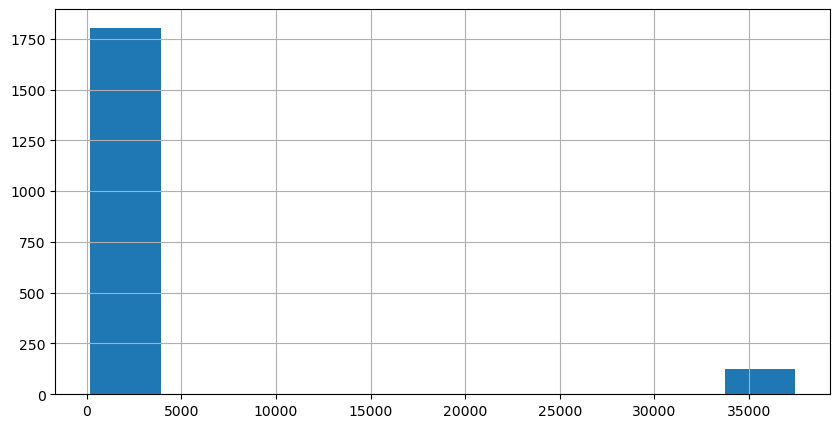

In [17]:
# На графике наблюдаем, что показатели выручки около сотни пользователей значительно превышают значения большей части группы
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
df.query('testgroup == "a" & revenue > 0').revenue.hist(ax=ax)

In [18]:
# Кол-во пользователей в контрольной группе с большой выручкой
df.query('testgroup == "a" & revenue > 0') \
    .groupby('user_id') \
    .agg({'revenue': 'sum'}) \
    .sort_values('revenue', ascending=False) \
    .query('revenue > 30000').reset_index().nunique().iloc[0]

123

In [19]:
# Выручка от таких пользователей в контрольной группе
df.query('testgroup == "a" & revenue > 0') \
    .groupby('user_id') \
    .agg({'revenue': 'sum'}) \
    .sort_values('revenue', ascending=False) \
    .query('revenue > 30000').reset_index().revenue.sum()

4590252

In [20]:
# Выручка в контрольной группе без "особых" пользователей
df.query('testgroup == "a" & revenue > 0 & revenue < 30000') \
    .groupby('user_id') \
    .agg({'revenue': 'sum'}) \
    .sort_values('revenue', ascending=False).revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

In [21]:
# Выручка в контрольной группе без "особых" пользователей
df.query('testgroup == "a" & revenue > 0 & revenue < 30000') \
    .groupby('user_id') \
    .agg({'revenue': 'sum'}) \
    .sort_values('revenue', ascending=False).revenue.sum()

545937

**Контрольная группа(а)**

- Средний показатель выручки по всей группе - **25.413720**;
- Общая выручка по всей группе - **5 136 189**;
- Количество платящих пользователей в группе - **1928**;
- Доля платящих пользователей в группе - **0.95%**;
- Средний показатель выручки по платящим пользователям в группе - **2663.998444**:
    - Минимальный показатель выручки по платящим пользователям в группе - **200**;
    - Максимальный показатель выручки по платящим пользователям в группе - **37433**;
- На **123** пользователя (**~6.4%**) приходится **89%** (**4 590 252**) выручки;
- При этом для остальных **1805** платящих пользователей средний показатель выручки равен **302** (**200** - минимальное значение, **400** - максимальное).

***Природа таких пользователей и их показателей нам не известна. Мы можем предполагать, что данные пользователи взаимодействовали с определенными акционными предложениями (механика которых также нам не известна), что привело к таким показателям выручки, но на данный момент анализа это выглядит подозрительно.*** 

***Возможно это особые пользователи (с привилегиями, подпиской и т.д.) или пользователи, попавшие на особые предложения в рамках теста.
Нельзя также исключать некоторую неточность на этапе сплитования групп для теста.***

Посмотрим далее на данные тестовой группы и попробуем прийти к заключению по этому вопросу.

In [22]:
#Тестовая группа
df.query('testgroup == "b"').revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [23]:
#Тестовая группа. Общая выручка
df.query('testgroup == "b"').revenue.sum()

5421603

In [24]:
#Тестовая группа. Средний показатель выручки
df.query('testgroup == "b"').revenue.describe().iloc[1]

26.75128659327863

In [25]:
#Тестовая группа. Платящие пользователи
df.query('testgroup == "b" & revenue > 0').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [26]:
#Тестовая группа. Доля платящих пользователей
df.query('testgroup == "b" & revenue > 0').user_id.nunique() / df.query('testgroup == "b"').user_id.nunique() * 100

0.8906235351586593

In [27]:
#Тестовая группа. Средний показатель выручки для платящих клиентов
df.query('testgroup == "b" & revenue > 0').revenue.describe().iloc[1]

3003.6581717451522

In [28]:
#Посмотрим на распределение выручки по пользователям в тестовой группе
df.query('testgroup == "b" & revenue > 0') \
    .groupby('user_id') \
    .agg({'revenue': 'sum'}) \
    .sort_values('revenue', ascending=False)

,revenue
user_id,
149619,4000
34358,4000
36473,3999
185455,3999
85615,3995
...,...
159970,2003
378688,2003
251211,2002


<Axes: >

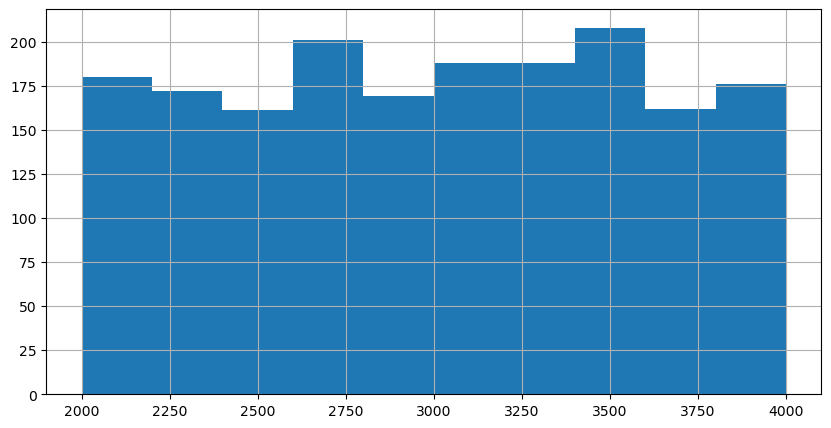

In [29]:
#В отличие от контрольной группы распределение показателей выручки пользователей достаточно равномерно - в пределах от 2000 до 4000
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
df.query('testgroup == "b" & revenue > 0').revenue.hist(ax=ax)

**Тестовая группа(b)**

- Средний показатель выручки по всей группе - **26.751287**;
- Общая выручка по всей группе - **5 421 603**;
- Количество платящих пользователей в группе - **1805**;
- Доля платящих пользователей в группе - **0.89%**;
- Средний показатель выручки по платящим пользователям в группе - **3003.658172**:
    - Минимальный показатель выручки по платящим пользователям в группе - **2000**;
    - Максимальный показатель выручки по платящим пользователям в группе - **4000**;

In [30]:
#Для наглядности соберем основные показатели в таблицу
data = {
    'group' : ['control', 'test'],
    'users' : [df.query('testgroup == "a"').user_id.nunique(), df.query('testgroup == "b"').user_id.nunique()],
    'revenue' : [df.query('testgroup == "a"').revenue.sum() , df.query('testgroup == "b"').revenue.sum()],
    'pay_users' : [df.query('testgroup == "a" & revenue > 0').user_id.nunique(), 
                   df.query('testgroup == "b" & revenue > 0').user_id.nunique()],
    'pay_users_share' : [df.query('testgroup == "a" & revenue > 0').user_id.nunique() 
                         / df.query('testgroup == "a"').user_id.nunique() * 100, 
                         df.query('testgroup == "b" & revenue > 0').user_id.nunique()
                         / df.query('testgroup == "b"').user_id.nunique() * 100],
    'ARPU' : [df.query('testgroup == "a"').revenue.describe().iloc[1], 
              df.query('testgroup == "b"').revenue.describe().iloc[1]],
    'ARPPU' : [df.query('testgroup == "a" & revenue > 0').revenue.describe().iloc[1], 
               df.query('testgroup == "b" & revenue > 0').revenue.describe().iloc[1]],
}

describe_df = pd.DataFrame(data)
describe_df

,group,users,revenue,pay_users,pay_users_share,ARPU,ARPPU
0,control,202103,5136189,1928,0.953969,25.413720,2663.998444
1,test,202667,5421603,1805,0.890624,26.751287,3003.658172


In [31]:
#Изменение в ARPU
(describe_df.ARPU[1] / describe_df.ARPU[0] - 1) * 100

5.263168360069903

In [32]:
#Изменение в ARPPU
(describe_df.ARPPU[1] / describe_df.ARPPU[0] - 1) * 100

12.749997227996346

In [33]:
#Изменение в доли платящих клиентов
(describe_df.pay_users_share[1] / describe_df.pay_users_share[0] - 1) * 100

-6.640203150326496

**Итого по анализу групп:**
- Средний показатель выручки по всем пользователям действительно больше в тестовой группе на **5%**;
- Средний показатель выручки по платящим пользователям больше в тестовой группе больше на **13%**;
- Доля платящих пользователей в тестовой группе меньше на **6.7%**;
- В контрольной группе на **6%** пользователей пришлось **89%** всей выручки, в тестовой группе показатели распределены равномерно (в пределах **2000** и **4000**) и подобных выбросов не наблюдается. При этом если не учитывать экстремальные значения выручки в контрольной группе, то показатели выручки из тестовой (ср.,мин.,макс.) выше в 10 раз.

Таким образом "особые" пользователи характерны только для контрольной группы. Несмотря на относительную схожесть средних показателей выручки по группам, получаются они максимально различно - если в тестовой группе показатели формируются равномерно по всем пользователям, то в контрольной серьезно влияет малая часть пользователей с высокими значениями, относительно бОльшей с низкими.

Каких-либо дополнительных данных, которые могли бы пролить свет на такое распределение выручки в группах у нас нет, поэтому мы по сути остаемся с двумя равноценными предположениями:

- На этапе сплитования групп были допущены неточности, что привело к таким результатам;
- Пользователи в контрольной группе случайно взаимодействовали с максимально полярными акционными предложениями (или ,к примеру, использовали свой статус/подписку для таких предложений) в отличии от пользователей в тестовой.

С учетом этого будем исходить из того, что это второй вариант возможны следующие шаги:

- Применить статистические тесты к полученным данным
- При выводах (в пользу какой-либо из групп) предложить повторно провести тестирование с учетом имеющегося опыта и крайне осторожно отнестись к результатам (плохим или хорошим)

**Выбор метрик для анализа**

На основе полученных данных и сферы деятельности компании можно предложить следующие метрики:

- **ARPU** - среднее значение выручки по всем пользователям в группах;
- **ARPPU** - среднее значение выручки по платящим пользователям в группах;
- **Конверсия в платящего пользователя (CR to PU)** - процент платящих пользователей от общего кол-ва пользователей

"ARPPU" и "CR to PU" могут рассматриваться как наиболее важные метрики с точки зрения того, что глобально мобильные игры часто зарабатывают лишь на небольшой доле пользователей (те самые платящие), которые генерируют большую часть доходов с пользователей. Акционные предложения в данном тесте как раз должны влиять на долю платящих пользователей и доходы от них.

**Выбор статистических тестов для анализа метрик**

Показатели **ARPU** и **ARPPU** являются средними значениями двух выборок, поэтому можно рассмотреть применение **t-теста**.
Однако есть специальные условия для его применения:

- Дисперсии внутри групп должны быть примерно одинаковы*;
- Данные обеих групп должны быть нормально распределены**.

* В случае неравенства дисперсий внутри групп можно воспользоваться модификацией t-критерия Стюдента - критерием Уэлча 

На практике c выборками больших размеров требованием к нормальности распределения данных из групп можно не следовать досконально и воспользоваться тестом для сравнения средних.

Показатель **конверсии в платящего пользователя**  является дискретным (0 - не было конверсии, 1 - была конверсия), поэтому можно обратиться к **критерию хи-квадрат**

**ARPU**

Проверим дисперсии на гомогенность с помощью критерия Левена

In [34]:
#Подготовим данные для теста
df_arpu_control = df.query('testgroup == "a"').revenue
df_arpu_test = df.query('testgroup == "b"').revenue

Гипотезы:

**H0** - Дисперсии равны

**H1** - Дисперсии не равны

P-value = **0.05**

In [35]:
if levene(df_arpu_control, df_arpu_test)[1] < 0.05:
    print('Отклоняем нулевую гипотезу о равенстве дисперсий между группами.')
    print(f'P-value равно {levene(df_arpu_control, df_arpu_test)[1]}.')
else:
    print('Не можем отклонить нулевую гипотезу о равенстве дисперсий между группами.')
    print(f'P-value равно {levene(df_arpu_control, df_arpu_test)[1]}.')

Не можем отклонить нулевую гипотезу о равенстве дисперсий между группами.
P-value равно 0.5324948591043842.


Дисперсии равны. 
Теперь посмотрим нормально ли распределение. Ранее на графике уже было видно, что выручка в контрольной группе имеет либо очень малые, либо очень большие значения, а в тестовой распределена равномерно

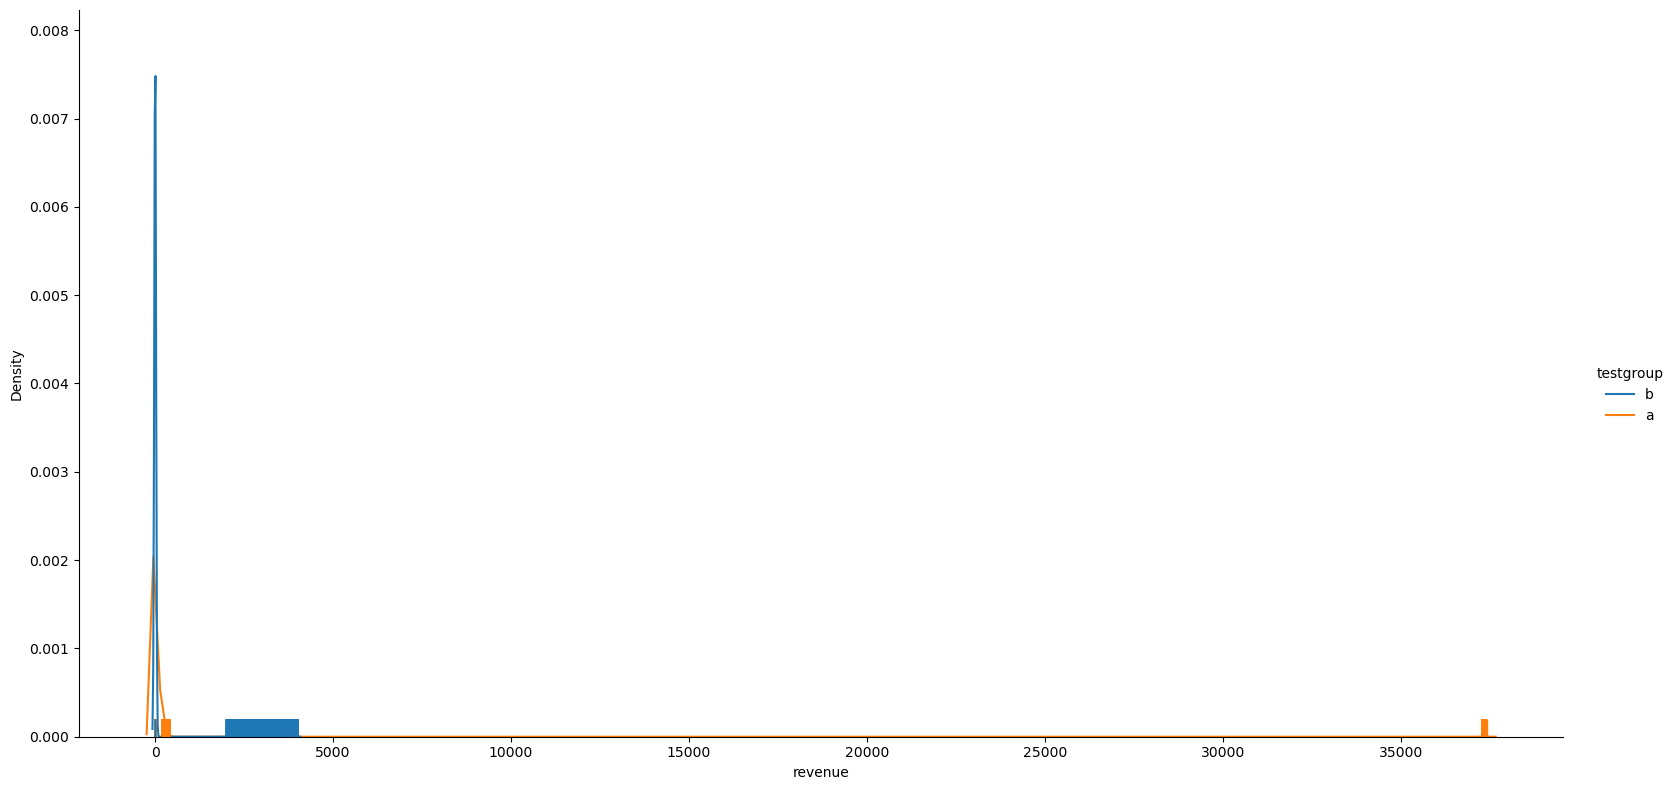

In [36]:
#Такое распределение точно нельзя назвать нормальным ни для контрольной(a), ни для тестовой(b) групп
sns.displot(data=df, x="revenue", hue="testgroup", kind="kde", rug=True, height=8, aspect=2)

Ранее отметили, что большой размер выборок позволяет применять тест при отсутствии нормального распределения данных, поэтому приступим

Гипотезы:

**H0** - Показатель ARPU в контрольной и тестовой группах не отличается 

**H1** - Показатель ARPU в контрольной и тестовой группах отличается

P-value = **0.05**

In [37]:
if stats.ttest_ind(a=df_arpu_control, b=df_arpu_test)[1] < 0.05:
    print('Отклоняем нулевую гипотезу об отсутствии различий показателя ARPU между группами.')
    print(f'P-value равно {stats.ttest_ind(a=df_arpu_control, b=df_arpu_test)[1]}.')
else:
    print('Не можем отклонить нулевую гипотезу об отсутствии различий показателя ARPU между группами.')
    print(f'P-value is {stats.ttest_ind(a=df_arpu_control, b=df_arpu_test)[1]}.')

Не можем отклонить нулевую гипотезу об отсутствии различий показателя ARPU между группами.
P-value is 0.532494858971837.


По результатам теста можем принять нулевую гипотезу об отсутствии различий между группами по показателю ARPU

**ARPPU**

Проверим дисперсии на гомогенность с помощью критерия Левена

In [38]:
#Подготовим данные для теста
df_arppu_control = df.query('testgroup == "a" & revenue > 0').revenue
df_arppu_test = df.query('testgroup == "b" & revenue > 0').revenue

Гипотезы:

**H0** - Дисперсии равны

**H1** - Дисперсии не равны

P-value = **0.05**

In [39]:
if levene(df_arppu_control, df_arppu_test)[1] < 0.05:
    print('Отклоняем нулевую гипотезу о равенстве дисперсий между группами.')
    print(f'P-value равно {levene(df_arppu_control, df_arppu_test)[1]}.')
else:
    print('Не можем отклонить нулевую гипотезу о равенстве дисперсий между группами.')
    print(f'P-value равно {levene(df_arppu_control, df_arppu_test)[1]}.')

Отклоняем нулевую гипотезу о равенстве дисперсий между группами.
P-value равно 3.779689868667878e-19.


Дисперсии не равны. Также посмотрим на нормальность распределения

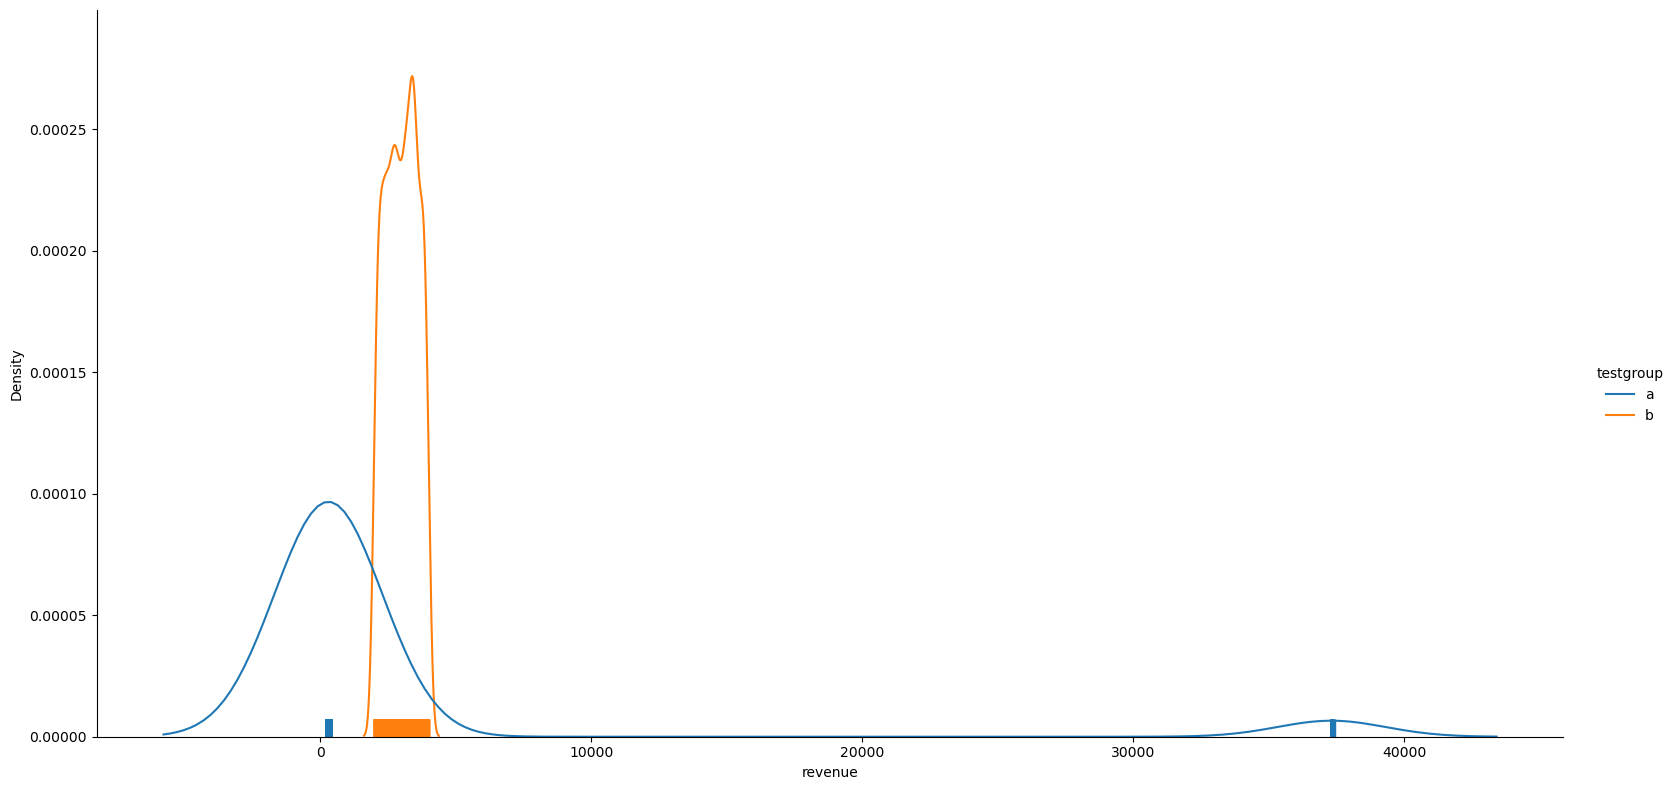

In [40]:
#Такое распределение точно нельзя назвать нормальным ни для контрольной(a), ни для тестовой(b) групп
revenue_df = df.groupby(['user_id', 'testgroup'], as_index = False).sum('revenue').query('revenue > 0')
sns.displot(data=revenue_df, x="revenue", hue="testgroup", kind="kde", rug=True, height=8, aspect=2)

В случае неравенства дисперсий и большого размера выборок можем воспользоваться модификацией t-критерия Стюдента - критерием Уэлча (добавляем настройку equal_var=False)

Гипотезы:

**H0** - Показатель ARPPU в контрольной и тестовой группах не отличается 

**H1** - Показатель ARPPU в контрольной и тестовой группах отличается

P-value = **0.05**

In [41]:
if stats.ttest_ind(a=df_arppu_control, b=df_arppu_test, equal_var=False)[1] < 0.05:
    print('Отклоняем нулевую гипотезу об отсутствии различий показателя ARPU между группами.')
    print(f'P-value равно {stats.ttest_ind(a=df_arppu_control, b=df_arppu_test)[1]}.')
else:
    print('Не можем отклонить нулевую гипотезу об отсутствии различий показателя ARPU между группами.')
    print(f'P-value is {stats.ttest_ind(a=df_arppu_control, b=df_arppu_test)[1]}.')

Не можем отклонить нулевую гипотезу об отсутствии различий показателя ARPU между группами.
P-value is 0.11153459157259497.


По результатам теста можем принять нулевую гипотезу об отсутствии различий между группами по показателю ARPPU

**CR**

In [42]:
#Подготовим таблицу сопряженности - для этого нам нужны данные по клиентам, которые совершали оплату (pay_users) 
#и те кто ее не совершал (no_pay_users) для обеих групп (0 - контрольная, 1 - тестовая)
describe_df['no_pay_users'] = describe_df['users'] - describe_df['pay_users']
df_cr = describe_df[['pay_users', 'no_pay_users']].transpose()
df_cr

,0,1
pay_users,1928,1805
no_pay_users,200175,200862


Воспользуемся критерием хи-квадрат для оценки изменений в конверсиях

Гипотезы:

**H0** - Показатель **CR** в контрольной и тестовой группах не отличается 

**H1** - Показатель **CR** в контрольной и тестовой группах отличается

P-value = **0.05**

In [43]:
if chi2_contingency(df_cr)[1] < 0.05:
    print('Отклоняем нулевую гипотезу об отсутствии различий показателя CR между группами.')
    print(f'P-value равно {chi2_contingency(df_cr)[1]}.')
else:
    print('Не можем отклонить нулевую гипотезу об отсутствии различий показателя CR между группами.')
    print(f'P-value is {chi2_contingency(df_cr)[1]}.')

Отклоняем нулевую гипотезу об отсутствии различий показателя CR между группами.
P-value равно 0.03647561892312613.


По результатам теста не можем принять нулевую гипотезу об отсутствии  различий в коверсиях между группами - конверсия в платящих пользователей в тестовой группе ниже на 6,4%

## Вывод

In [44]:
#Подготовим таблицу для наглядности
conclusion_df = describe_df[['ARPU', 'ARPPU', 'pay_users_share']].transpose()
conclusion_df['diff_percentage'] = (conclusion_df[1] / conclusion_df[0] - 1) * 100
conclusion_df['significance'] = ['Not Significant','Not Significant','Significant']
conclusion_df

,0,1,diff_percentage,significance
ARPU,25.413720,26.751287,5.263168,Not Significant
ARPPU,2663.998444,3003.658172,12.749997,Not Significant
pay_users_share,0.953969,0.890624,-6.640203,Significant


Результатом проведенных тестов стали отсутствие стат.значимых различий по метрикам ARPU и ARPPU между контрольной и тестовой группами, а также значимое различие в пользу контрольной группы по показателю конверсии в платящего пользователя. 

Акционные предложения, которые предоставлялись в контрольной группе, активнее конвертируют пользователей в источник дохода. Также можно предположить, что чем больше  платящих пользователей будет аккумулироваться благодаря таким предложениям, тем выше потенциально будет становиться показатель ARPU (не радикально выше, но все равно).

В таком разрезе было бы логично советовать идти далее с акционными предложениями из контрольной группы, **но** с учетом необычных данных, которые мы наблюдали при анализе было бы неплохо попробовать провести подобный тест еще раз, сделав акцент на этапе формирования групп 